In [1]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import humanize
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import editdistance
from tqdm import tqdm


In [2]:
method_palette = { "LoFreq": "#9593D9",
                   "ShoRAH": "#ffe66d",
                   "CliqueSNV":  "#4ecdc4",
                   "VILOCA": "#ff6b6b",
                   "PredictHaplo": "#227c9d",
                   "ground_truth": "grey",
                  "ground truth": "grey",
                  }

mapping_methods = {
    'cliquesnv_local_haplo_snv_tf0.01': "CliqueSNV",
    'cliquesnv_local_haplo_snv': "CliqueSNV",
    'cliquesnv_local_haplo_tf0.01': "CliqueSNV",
    'cliquesnv_local_haplo_tf0.1':"CliqueSNV",
    'cliquesnv_local_haplo': "CliqueSNV",
    'shorah_default': 'ShoRAH',
    'lofreq_local_haplo': 'LoFreq',
    'viloca_alpha_0.00001': 'VILOCA',
    'viloca_alpha_0.00001_K100': 'VILOCA',
    'viloca_multi': 'VILOCA',
    'ground_truth': "ground truth",
    'predicthaplo_local_haplo': 'PredictHaplo'
}

In [3]:
mapping_haplos = {
    '2@3@30@20@20@geom@0.75': 'Population 1', 
    '5@5@30@10@15@geom@0.75': 'Population 2',
    '5@10@30@10@10@geom@0.75': 'Population 3', 
    '5@15@30@10@15@geom@0.75': 'Population 4', 
    
    '2@3@600@400@400@geom@0.75': 'Population 5',
    '2@3@600@600@600@geom@0.75': 'Population 6',
    '5@5@600@200@300@geom@0.75': 'Population 7', 
    '5@10@600@200@240@geom@0.75': 'Population 8',
}

In [4]:
fname_global =  "results/distance/performance_measures/global/csv_files/pr_results.csv"
fname_mds = 'results/distance/performance_measures/global/csv_files/mds_results.csv.gz'

# for computation of precision recall for differnt posterior thresholds
fname_pred = 'results/distance/performance_measures/global/csv_files/predictions.csv.gz'
df_pred = pd.read_csv(fname_pred)

fname_true = 'results/distance/performance_measures/global/csv_files/ground_truth.csv.gz'
df_true = pd.read_csv(fname_true)

## mds plots

In [5]:
df_mds = pd.read_csv(fname_mds)
df_mds.loc[:,'coverage'] = df_mds['params'].str.split('~').str[6].str.split('__').str[0]
df_mds.loc[:, 'haplos'] = df_mds['params'].str.split('~').str[7].str.split('\n').str[0]
df_mds.loc[:, 'seq_tech'] = df_mds['params'].str.split('~').str[1].str.split('__').str[0]

#df_mds = df_mds[df_mds['method'].isin(methods_order)]
df_mds["Method"] = df_mds['method'].apply(lambda x: mapping_methods[x])
#df_mds = df_mds[df_mds['haplos'].isin(populations_long + populations_short)]
df_mds["Population"] = df_mds['haplos'].apply(lambda x: mapping_haplos[x])

# prepare mds plot

def f_freq_bins(x):
    if x>0.2:
        return 0.3
    elif x>0.1:
        return 0.2
    elif x>0.05:
        return 0.1
    elif x>0.01:
        return 0.05
    elif x<=0.01:
        return 0.01
    
df_mds["Frequency"] = df_mds["frequency"].apply(f_freq_bins)

# filter out only results with high posterior for viloca samples
df_mds = df_mds[(df_mds['posterior'].isnull()) | (df_mds['posterior']>=0.90)]

In [6]:
df_mds['method'].unique()

array(['cliquesnv_local_haplo_tf0.01', 'viloca_alpha_0.00001',
       'ground_truth', 'cliquesnv_local_haplo_tf0.1',
       'predicthaplo_local_haplo'], dtype=object)

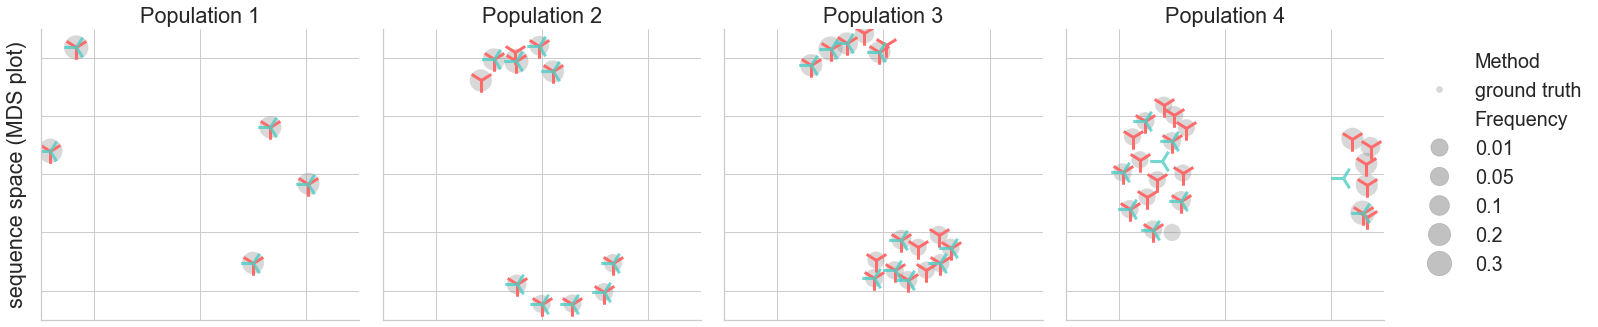

In [119]:
sns.set_theme(style="whitegrid", font_scale=1.8)

rep_id = 1
marker_viloca = "1"
marker_cliquesnv = "3"
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["ground truth"]))]

g = sns.relplot(data=df_plot.sort_values("Method",  key=np.vectorize(method_order.index)), 
            kind="scatter", 
            x="MDS0", 
            y="MDS1", 
            col="Population",
            size="Frequency",
            hue="Method", 
            col_order=['Population 1', 'Population 2', 'Population 3', 'Population 4'] ,
            markers=markers,
            hue_order= method_order, 
            style_order = method_order, 
            style="Method", 
            sizes=(300, 600),
            palette=method_palette,
            alpha=0.3,
            linewidth=0.5,
            legend=True,  
            )

ax0 = g.fig.axes[0]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 1")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca,s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 1")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)

ax1 = g.fig.axes[1]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 2")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 2")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)

ax2 = g.fig.axes[2]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 3")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 3")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv,c="#4ecdc4", s=600, linewidth=3, alpha =0.8)

ax3 = g.fig.axes[3]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 4")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 4")
                 & (df_mds['seq_tech'].isin(["illumina"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)

g.set_titles(col_template='{col_name}', fontsize=35)
g.set_xticklabels("")
g.set_yticklabels("")
g.set(xlabel ="")
g.set(ylabel ="sequence space (MDS plot)")

g.set(ylim=(-25,25), xlim=(-30, 30))
g.tight_layout()

g.savefig("distance_haplos_illumina_mds.svg")

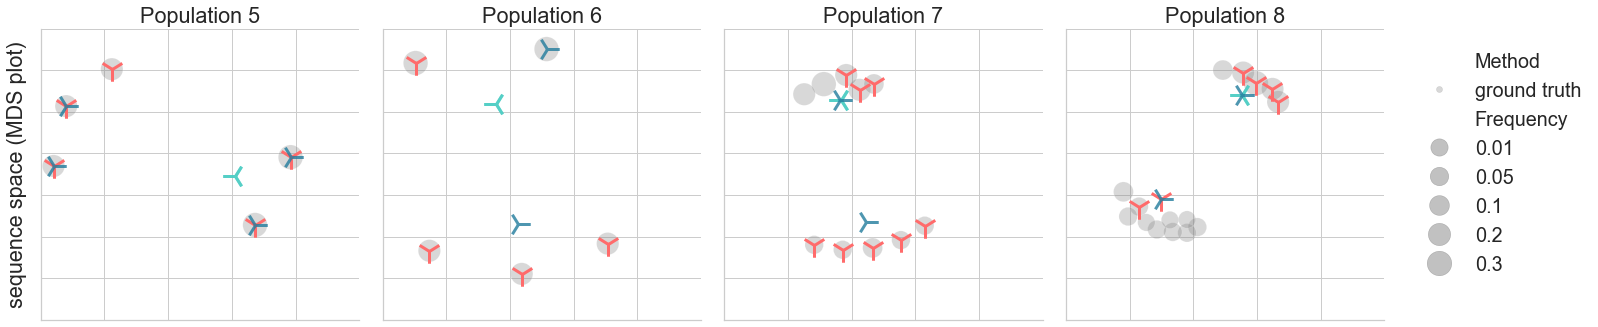

In [21]:
sns.set_theme(style="whitegrid", font_scale=1.8)

rep_id = 0
marker_viloca = "1"
marker_cliquesnv = "3"
marker_predicthaplo = "4"
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["ground truth"]))]

g = sns.relplot(data=df_plot, 
            kind="scatter", 
            x="MDS0", 
            y="MDS1", 
            col="Population",
            size="Frequency",
            hue="Method", 
            col_order=['Population 5', 'Population 6', 'Population 7', 'Population 8'] ,
            markers=["o"],
            #hue_order= , 
            #style_order = method_order, 
            style="Method", 
            sizes=(300, 600),
            palette=method_palette,
            alpha=0.3,
            linewidth=0.5,
            legend=True,  
            )

ax0 = g.fig.axes[0]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 5")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca,s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 5")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 5")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo, c="#227c9d", s=600, linewidth=3, alpha =0.8)



ax1 = g.fig.axes[1]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 6")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 6")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 6")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo, c="#227c9d", s=600, linewidth=3, alpha =0.8)



ax2 = g.fig.axes[2]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 7")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 7")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv,c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 7")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo,c="#227c9d", s=600, linewidth=3, alpha =0.8)



ax3 = g.fig.axes[3]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 8")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 8")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 8")
                 & (df_mds['seq_tech'].isin(["pacbio"]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo, c="#227c9d", s=600, linewidth=3, alpha =0.8)



g.set_titles(col_template='{col_name}', fontsize=35)
g.set_xticklabels("")
g.set_yticklabels("")
g.set(xlabel ="")
g.set(ylabel ="sequence space (MDS plot)")

g.tight_layout()

g.savefig("distance_haplos_pacbio_mds.svg")

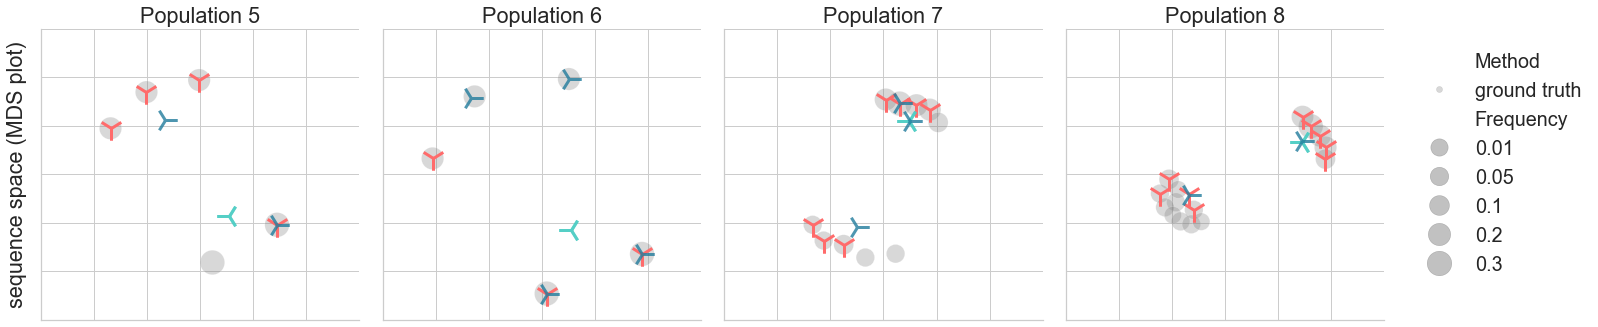

In [25]:
sns.set_theme(style="whitegrid", font_scale=1.8)

rep_id = 0
marker_viloca = "1"
marker_cliquesnv = "3"
marker_predicthaplo = "4"

seq_tech = 'nanopore'
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["ground truth"]))]

g = sns.relplot(data=df_plot, 
            kind="scatter", 
            x="MDS0", 
            y="MDS1", 
            col="Population",
            size="Frequency",
            hue="Method", 
            col_order=['Population 5', 'Population 6', 'Population 7', 'Population 8'] ,
            markers='o',
            style="Method", 
            sizes=(300, 600),
            palette=method_palette,
            alpha=0.3,
            linewidth=0.5,
            legend=True,  
            )

ax0 = g.fig.axes[0]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 5")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca,s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 5")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 5")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax0.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo, c="#227c9d", s=600, linewidth=3, alpha =0.8)



ax1 = g.fig.axes[1]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 6")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 6")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 6")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax1.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo, c="#227c9d", s=600, linewidth=3, alpha =0.8)



ax2 = g.fig.axes[2]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 7")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 7")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv,c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 7")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax2.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo,c="#227c9d", s=600, linewidth=3, alpha =0.8)



ax3 = g.fig.axes[3]
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 8")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["VILOCA"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], color="#ff6b6b", marker=marker_viloca, s=600, linewidth=3)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 8")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["CliqueSNV"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=3, alpha =0.8)
df_plot = df_mds[(df_mds["replicate"]==rep_id) 
                 & (df_mds['coverage'].isin(["1000"]))
                 & (df_mds['Population']=="Population 8")
                 & (df_mds['seq_tech'].isin([seq_tech]))
                 & (df_mds['Method'].isin(["PredictHaplo"]))]
ax3.scatter(df_plot["MDS0"], df_plot["MDS1"], marker=marker_predicthaplo, c="#227c9d", s=600, linewidth=3, alpha =0.8)



g.set_titles(col_template='{col_name}', fontsize=35)
g.set_xticklabels("")
g.set_yticklabels("")
g.set(xlabel ="")
g.set(ylabel ="sequence space (MDS plot)")

g.tight_layout()

g.savefig("distance_haplos_ont_mds.svg")

## for viloca: compute posterior threshold pr-values

In [7]:
def relative_edit_distance(seq1, seq2):
    dist = editdistance.eval(seq1, seq2)
    rel = dist / max(len(seq1), len(seq2))
    return rel


def pr_worker(index, df_group, df_true, thres):
    (method, params, replicate) = index

    tp = 0
    fp = 0
    fn = 0

    df_true_grpd = df_true[
        (df_true["params"] == params) & (df_true["replicate"] == replicate)
    ]

    # subsample large results
    max_num = 500
    df_group = df_group.sample(n=min(df_group.shape[0], max_num))

    # true positive: predicted seq appears in ground truth
    # false positive: predicted seq does not appear in ground truth
    df_cur = df_true_grpd.copy()
    for row in tqdm(df_group.itertuples(), total=df_group.shape[0], leave=False):
        ser_dist = df_cur["sequence"].apply(
            lambda x: relative_edit_distance(x, row.sequence)
        )
        passed_thres = (ser_dist <= thres).any()

        if passed_thres:
            tp += 1

            # remove ground truth because it was predicted
            df_cur = df_cur.drop(ser_dist.idxmin())
        else:
            fp += 1

    # false negative: ground truth sequence was not predicted
    # single prediction should not map to multiple ground truth seqs
    df_cur = df_group.copy()
    for row in tqdm(
        df_true_grpd.itertuples(), total=df_true_grpd.shape[0], leave=False
    ):
        ser_dist = df_cur["sequence"].apply(
            lambda x: relative_edit_distance(x, row.sequence)
        )
        passed_thres = (ser_dist <= thres).any()

        if not passed_thres:
            fn += 1
        else:
            # remove current prediction
            df_cur = df_cur.drop(ser_dist.idxmin())
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    # finalize
    return {
        "method": method,
        "params": params,
        "replicate": replicate,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": tp / (tp + fp),
        "recall": tp / (tp + fn),
        "f1": 0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall), 
    }

In [8]:
distance_threshold = 0.01

posterior_thresholds = [0.0, 0.5, 0.9]

# Goal dataframe with the following columns
# params, method, replicate, posterior_threshold, precison, recall, f1

tmp = []

for posterior_threshold in posterior_thresholds:
    df_pred_tmp = df_pred[df_pred['posterior']>posterior_threshold]
    for index, df_group in df_pred_tmp.groupby(["method", "params", "replicate"]):

        pr_list = pr_worker(index, df_group, df_true, distance_threshold)
        pr_list['posterior_threshold'] = posterior_threshold
        tmp.append(pr_list)
                                                   
df_pr = pd.DataFrame(tmp) 

In [9]:
df_pr_precision = df_pr[['precision', 'method', 'replicate', 'params', 'posterior_threshold']]
df_pr_precision['value']= df_pr_precision['precision']
df_pr_precision['variable']='precision'
df_pr_precision = df_pr_precision[['variable','value', 'method', 'replicate', 'params', 'posterior_threshold']]


df_pr_recall = df_pr[['recall', 'method', 'replicate', 'params', 'posterior_threshold']]
df_pr_recall['value']= df_pr_recall['recall']
df_pr_recall['variable']='recall'
df_pr_recall = df_pr_recall[['variable','value', 'method', 'replicate', 'params', 'posterior_threshold']]

df_pr_f1 = df_pr[['f1', 'method', 'replicate', 'params', 'posterior_threshold']]
df_pr_f1['value']= df_pr_f1['f1']
df_pr_f1['variable']='f1'
df_pr_f1 = df_pr_f1[['variable','value', 'method', 'replicate', 'params', 'posterior_threshold']]


df_pr_long = pd.concat([df_pr_recall, df_pr_precision, df_pr_f1])

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_8414/1643034023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr_precision['value']= df_pr_precision['precision']
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_8414/1643034023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr_precision['variable']='precision'
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_8414/1643034023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [10]:
df_viloca = df_pr_long[df_pr_long['posterior_threshold']>=0.9]

In [11]:
df_viloca.head()

,variable,value,method,replicate,params,posterior_threshold
278,recall,1.0,viloca_alpha_0.00001,0,seq_tech~illumina__seq_mode~shotgun__seq_mode_...,0.9
279,recall,1.0,viloca_alpha_0.00001,1,seq_tech~illumina__seq_mode~shotgun__seq_mode_...,0.9
280,recall,1.0,viloca_alpha_0.00001,2,seq_tech~illumina__seq_mode~shotgun__seq_mode_...,0.9
281,recall,1.0,viloca_alpha_0.00001,4,seq_tech~illumina__seq_mode~shotgun__seq_mode_...,0.9
282,recall,1.0,viloca_alpha_0.00001,0,seq_tech~illumina__seq_mode~shotgun__seq_mode_...,0.9


In [12]:
df_haplo = pd.read_csv(fname_global)
df_haplo = df_haplo[df_haplo['method'].isin(['cliquesnv_local_haplo_tf0.01', 'predicthaplo_local_haplo'])]


# compute f1 score
df_haplo["f1"] = 2 * (df_haplo["precision"] * df_haplo["recall"]) / (df_haplo["precision"] + df_haplo["recall"]) 
df_haplo["f1"] = df_haplo["f1"].fillna(0)

# transform dataframe in right format
df_haplo = pd.melt( df_haplo, 
                    id_vars=["params", "replicate",  "method"], 
                    value_vars= ["precision", "recall", "f1"], 
                    var_name="variable", 
                    value_name="value", 
                    ignore_index=True)

df = pd.concat([df_viloca, df_haplo])

df.loc[:,'coverage'] = df['params'].str.split('~').str[6].str.split('__').str[0]
df.loc[:, 'haplos'] = df['params'].str.split('~').str[7].str.split('\n').str[0]
df.loc[:, 'seq_tech'] = df['params'].str.split('~').str[1].str.split('__').str[0]

df["Method"] = df['method'].apply(lambda x: mapping_methods[x])
df["Population"] = df['haplos'].apply(lambda x: mapping_haplos[x])

In [28]:
df[(df['Method']=='PredictHaplo') 
   & (df['Population'].isin(["Population 5", "Population 6"])) 
   & (df['coverage']=="1000")
   & (df['variable']=="recall")]['value'].min()

0.2

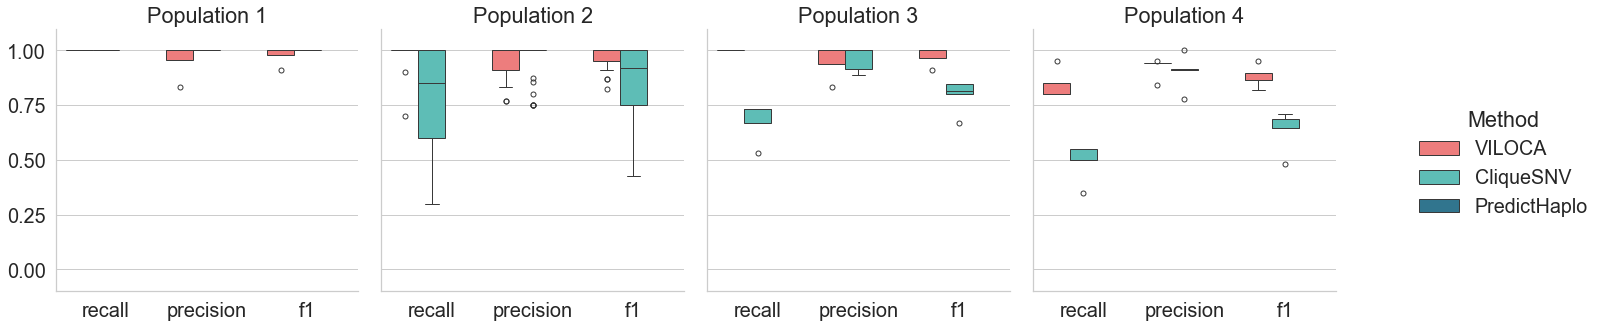

In [40]:
sns.set_theme(style="whitegrid", font_scale=1.8)

g = sns.catplot(
        data=df,
        x="variable",
        y="value",
        hue="Method",
        col="Population",
        kind="box",
        col_order=["Population 1", "Population 2", "Population 3", "Population 4"],
        legend=True, 
        palette=method_palette,
        sharex=True,
        sharey=True,
        margin_titles=True,
    )
g.set_titles(col_template='{col_name}')


g.set(ylim=(-0.1, 1.1))
g.set_xticklabels(size=20)
g.set(xlabel ="")
g.set(ylabel ="")

g.tight_layout()
g.savefig("distance_haplos_pr_illumina.svg")

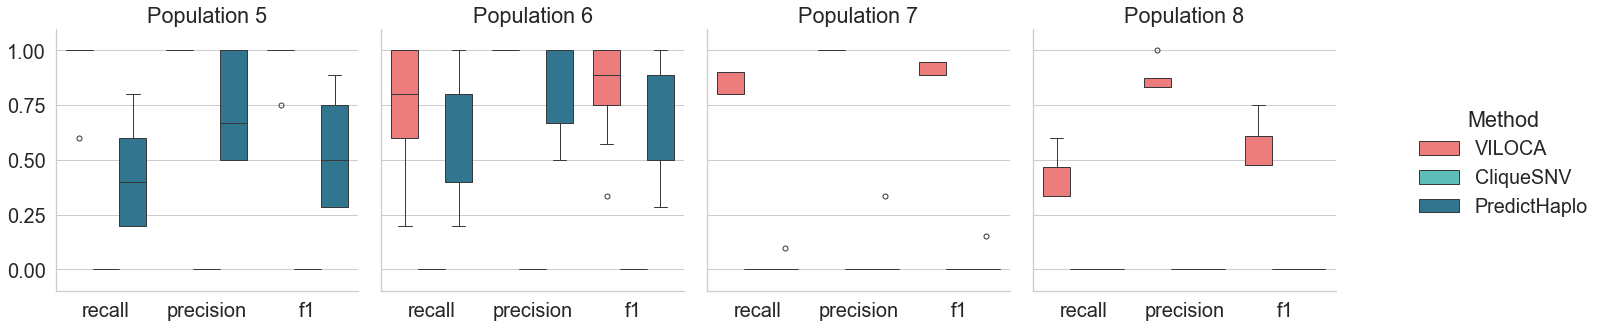

In [41]:
sns.set_theme(style="whitegrid", font_scale=1.8)

g = sns.catplot(
        data=df[df['seq_tech']=='pacbio'],
        x="variable",
        y="value",
        hue="Method",
        col="Population",
        kind="box",
        col_order=["Population 5", "Population 6", "Population 7", "Population 8"],
        legend=True, 
        palette=method_palette,
        sharex=True,
        sharey=True,
        margin_titles=True,
    )
g.set_titles(col_template='{col_name}')


g.set(ylim=(-0.1, 1.1))
g.set_xticklabels(size=20)
g.set(xlabel ="")
g.set(ylabel ="")

g.tight_layout()
g.savefig("distance_haplos_pr_pacbio.svg")

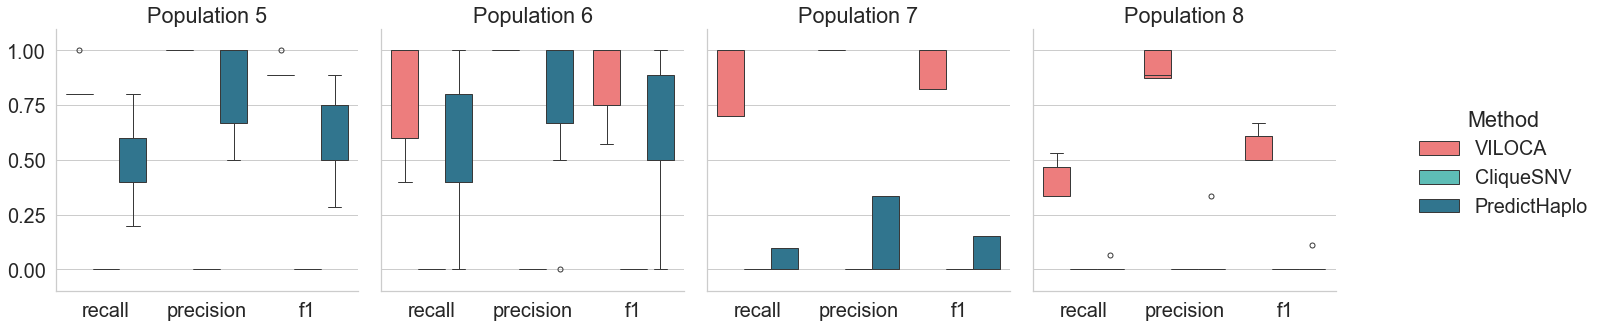

In [42]:
sns.set_theme(style="whitegrid", font_scale=1.8)

g = sns.catplot(
        data=df[df['seq_tech']=='nanopore'],
        x="variable",
        y="value",
        hue="Method",
        col="Population",
        kind="box",
        col_order=["Population 5", "Population 6", "Population 7", "Population 8"],
        legend=True, 
        palette=method_palette,
        sharex=True,
        sharey=True,
        margin_titles=True,
    )
g.set_titles(col_template='{col_name}')


g.set(ylim=(-0.1, 1.1))
g.set_xticklabels(size=20)
g.set(xlabel ="")
g.set(ylabel ="")

g.tight_layout()
g.savefig("distance_haplos_pr_ont.svg")

In [44]:
df[(df['seq_tech']=='pacbio') 
   & (df['Method']=='PredictHaplo') 
   & (df['Population']=='Population 5')
   & (df['variable']=='recall')]

,variable,value,method,replicate,params,posterior_threshold,coverage,haplos,seq_tech,Method,Population
407,recall,0.8,predicthaplo_local_haplo,0,seq_tech~pacbio__seq_mode~shotgun__seq_mode_pa...,NaN,1000,2@3@600@400@400@geom@0.75,pacbio,PredictHaplo,Population 5
408,recall,0.2,predicthaplo_local_haplo,1,seq_tech~pacbio__seq_mode~shotgun__seq_mode_pa...,NaN,1000,2@3@600@400@400@geom@0.75,pacbio,PredictHaplo,Population 5
409,recall,0.2,predicthaplo_local_haplo,2,seq_tech~pacbio__seq_mode~shotgun__seq_mode_pa...,NaN,1000,2@3@600@400@400@geom@0.75,pacbio,PredictHaplo,Population 5
410,recall,0.6,predicthaplo_local_haplo,3,seq_tech~pacbio__seq_mode~shotgun__seq_mode_pa...,NaN,1000,2@3@600@400@400@geom@0.75,pacbio,PredictHaplo,Population 5
411,recall,0.4,predicthaplo_local_haplo,4,seq_tech~pacbio__seq_mode~shotgun__seq_mode_pa...,NaN,1000,2@3@600@400@400@geom@0.75,pacbio,PredictHaplo,Population 5
